In [ ]:
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import gaussian_kde
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib import pyplot
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings('ignore')


In [ ]:
all_30_prot=['CPSM_MOUSE','FAS_MOUSE', 'SARDH_MOUSE','AL1L1_MOUSE','CLH1_MOUSE','DHE3_MOUSE','PYC_MOUSE', 'ASSY_MOUSE','PYGL_MOUSE',
'ATPB_MOUSE','M2GD_MOUSE','THIM_MOUSE','CH60_MOUSE','HMCS2_MOUSE''ADH1_MOUSE','ECHA_MOUSE','SBP1_MOUSE','ATPA_MOUSE','AL1A1_MOUSE'
'HYES_MOUSE','ALBU_MOUSE','TKT_MOUSE', 'AOXC_MOUSE','K2C8_MOUSE','ALDH2_MOUSE','MYH9_MOUSE','EF2_MOUSE', 'FAAA_MOUSE','G3P_MOUSE', 
'SPTN1_MOUSE','AATM_MOUSE',  'BHMT1_MOUSE', 'F16P1_MOUSE', 'MMSA_MOUSE',  ]

In [ ]:
def getAllRateInfo(path):
    res=pd.DataFrame()
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CPSM_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'CH60_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'FAS_MOUSE.' in x  ]
    # files=[x for x in os.listdir(path) if 'RateConst.csv' in x and 'SARDH_MOUSE.' in x  ]    
    files=[x for x in os.listdir(path) if 'RateConst.csv' in x and x.replace('.RateConst.csv','') in all_30_prot  ]
    for f in tqdm(files):
        try:
            temp=pd.read_csv(os.path.join(path,f))
            temp=temp.dropna()
            temp['Protein']=f.replace('.RateConst.csv','')
            res=pd.concat([res,temp])
        except Exception as exp:
            print(f,exp)
    res.columns=[x.strip() for x in res.columns]
    return res
def read_n_merge(orignial_data,skip,file,folder_path):
    file_data=pd.read_csv(os.path.join(folder_path,file),skiprows=skip,index_col=False)
    file_data.columns=[x.strip() for x in file_data.columns]
    isparsed=(set(['Peptide', 'UniqueToProtein', 'Exchangeable Hydrogens', 'Charge',
       'm/z(Sequence)', 'M0', 'M1', 'M2', 'M3', 'M4']).issubset(set(file_data.columns)))
    isparsed=isparsed and file_data.shape[0]>0    
    if isparsed:
        file_data['Protein']=file.replace('.Quant.csv','')
        orignial_data=pd.concat([orignial_data,file_data])       
    return [isparsed,orignial_data]

def get_df_all_quant_files(path):
    # files=[x for x in os.listdir(path) if '.Quant.csv' in x  ]
    # files=[x for x in os.listdir(path) if 'CPSM_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'CH60_MOUSE.Quant.csv' in x  ] 
    # files=[x for x in os.listdir(path) if 'FAS_MOUSE.Quant.csv' in x  ]   
    # files=[x for x in os.listdir(path) if 'SARDH_MOUSE.Quant.csv' in x  ]   
    files=[x for x in os.listdir(path) if x.replace('.Quant.csv','') in all_30_prot   ]   
    all_data=pd.DataFrame()  
        
    for index in tqdm(range(len(files))):            
        res=read_n_merge(all_data,1,files[index],path)
        # print(res)
        if res[0]:
            all_data=res[1]
        else:
            all_data=read_n_merge(all_data,3,files[index],path)[1]
    all_data=all_data.reset_index(drop=True)
    all_data.columns=[x.strip() for x in all_data.columns]
    return all_data

In [ ]:
path=r"\\UT321319\Shared_Folder\NEH_Dependence\liverpool_liver"

In [ ]:
quant=get_df_all_quant_files(path)
rate=getAllRateInfo(path)

100%|██████████| 30/30 [00:01<00:00, 15.07it/s]


In [ ]:
merged=pd.merge(quant,rate,left_on=['Protein','Peptide','Charge'],right_on=['Protein','Peptides','Charge'])
merged=merged[merged['Rsquared']>0.9].reset_index(drop=True)

In [ ]:
merged.RateConstants[(merged.RateConstants >= np.median(merged.RateConstants) - np.median(merged.RateConstants)*0.25) &
                  ((merged.RateConstants <= np.median(merged.RateConstants) + np.median(merged.RateConstants)*0.25))].shape[0]/merged.shape[0]

0.48091603053435117

In [ ]:
# for prot in all_30_prot[1:]: 
#     tempData=merged[merged.Protein==prot]
    
#     print(tempData.shape,tempData.RateConstants)

    
#     np=tempData.RateConstants[(tempData.RateConstants >= np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25) &
#                     ((tempData.RateConstants <= np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25))].shape[0]/tempData.shape[0]
    
#     print(prot,np)

In [ ]:
# tempData=merged[merged.Protein==all_30_prot[0]]
 


# np=tempData[(tempData.RateConstants >= np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25) &
#                 ((tempData.RateConstants <= np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25))].shape[0]/tempData.shape[0]

In [ ]:
res=[]
for prot in (all_30_prot):
    tempData=merged[merged.Protein==prot]
    if tempData.shape[0]==0: continue
    perncentage_p=tempData.RateConstants[(tempData.RateConstants >= np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25) &
                    ((tempData.RateConstants <= np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25))].shape[0]/tempData.shape[0]
    
    print(prot,perncentage_p)
    res.append(perncentage_p)

CPSM_MOUSE 0.810126582278481
FAS_MOUSE 0.7142857142857143
SARDH_MOUSE 0.8688524590163934
AL1L1_MOUSE 0.8392857142857143
CLH1_MOUSE 0.7027027027027027
DHE3_MOUSE 0.6938775510204082
PYC_MOUSE 0.7872340425531915
ASSY_MOUSE 0.7111111111111111
PYGL_MOUSE 0.6595744680851063
ATPB_MOUSE 0.9347826086956522
M2GD_MOUSE 0.7560975609756098
THIM_MOUSE 0.875
CH60_MOUSE 0.8292682926829268
ECHA_MOUSE 0.7380952380952381
SBP1_MOUSE 0.7058823529411765
ATPA_MOUSE 0.7073170731707317
ALBU_MOUSE 0.8620689655172413
TKT_MOUSE 0.9117647058823529
AOXC_MOUSE 0.7272727272727273
K2C8_MOUSE 0.7777777777777778
ALDH2_MOUSE 0.7333333333333333
MYH9_MOUSE 0.64
EF2_MOUSE 0.8064516129032258
FAAA_MOUSE 0.75
G3P_MOUSE 0.7272727272727273
SPTN1_MOUSE 0.8
AATM_MOUSE 0.7419354838709677
BHMT1_MOUSE 0.8529411764705882
F16P1_MOUSE 0.8928571428571429
MMSA_MOUSE 0.7


In [ ]:
np.mean(res),np.median(res),np.std(res)

(0.7752389708352747, 0.7530487804878049, 0.07670450085909859)

In [ ]:
len(res)

30

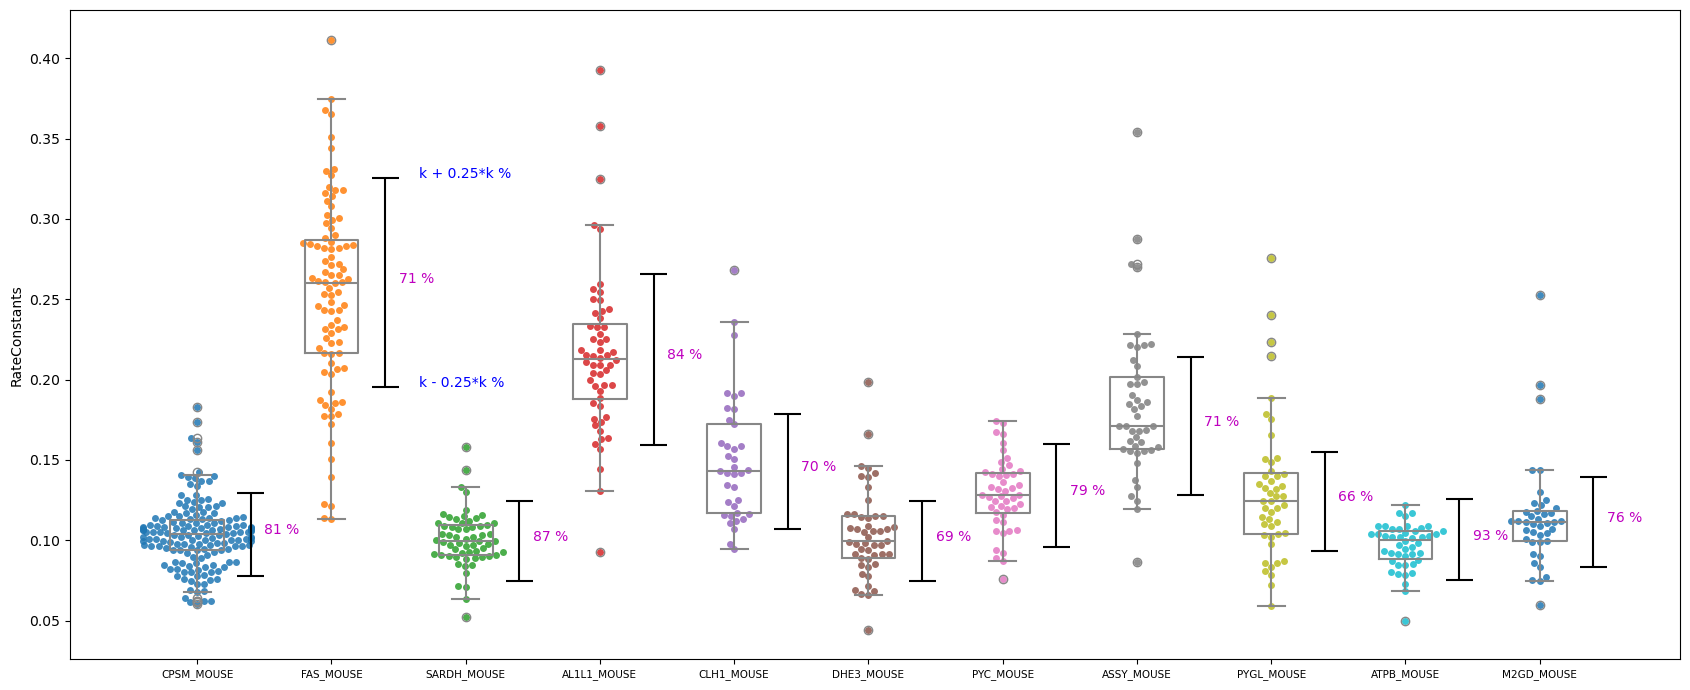

In [ ]:
res=[]
plt.figure(figsize=(17,7))
n_prot=10
for index,prot in enumerate(all_30_prot):
    tempData=merged[merged.Protein==prot]
    if tempData.shape[0]==0: continue
    
    perncentage_p=tempData.RateConstants[(tempData.RateConstants >= np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25) &
                    ((tempData.RateConstants <= np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25))].shape[0]/tempData.shape[0]
    
    sns.swarmplot(y=tempData.RateConstants,x=index,zorder=0,alpha=0.85)
    sns.boxplot(y=tempData.RateConstants,x=index,color='#878787',fill=False,width=0.4)
    # sns.boxenplot(y=tempData.RateConstants,x=index)
    
    plt.vlines(x=index+0.4,
               ymin=np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25,
               ymax=np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25,colors='k')
    plt.hlines(y=np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25,
               xmin=index+0.3,xmax=index+0.5,colors='k')
    plt.hlines(y=np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25,
               xmin=index+0.3,xmax=index+0.5,colors='k')
    plt.text(x=index+0.5,y=np.median(tempData.RateConstants),s=f"{100*perncentage_p:.0f} %",c='m')
    
    if index ==1:
        plt.text(x=index+0.65,y=np.median(tempData.RateConstants) + np.median(tempData.RateConstants)*0.25,s=f"k + 0.25*k %",c='blue')
        plt.text(x=index+0.65,y=np.median(tempData.RateConstants) - np.median(tempData.RateConstants)*0.25,s=f"k - 0.25*k %",c='blue')
        
    
    # print(prot,perncentage_p)
    res.append(perncentage_p)
    
    if index ==n_prot: break

plt.xticks( range(n_prot+1), all_30_prot[:n_prot+1],rotation=0,fontsize=7.5)    
# plt.show()
np.mean(res),np.median(res),np.std(res)

plt.tight_layout()
plt.savefig("rate_percentage_liver.jpeg",dpi=900)